In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
# import cv2
from keras.models import load_model
import tensorflow as tf
from keras import optimizers
import keras
import segmentation_models as sm
import metric
from commons import *
from PIL import Image

from architecture import create_model, create_callbacks


BACKUP_MODEL_PATH = "./../Models/backup.h5"
BACKUP_HISTORY_PATH = "./../Models/backup.csv"
seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 2

ROOT = "./../Data/karlsruhe/"
TRAIN_DIR = "_Test512/"

USE_AUGMENTATION = True

In [2]:
model = create_model(IMAGE_HEIGHT, IMAGE_WIDTH, filter_factor = 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_01 (Conv2D)             (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d_01[0][0]']              
 alization)                     )                                                             

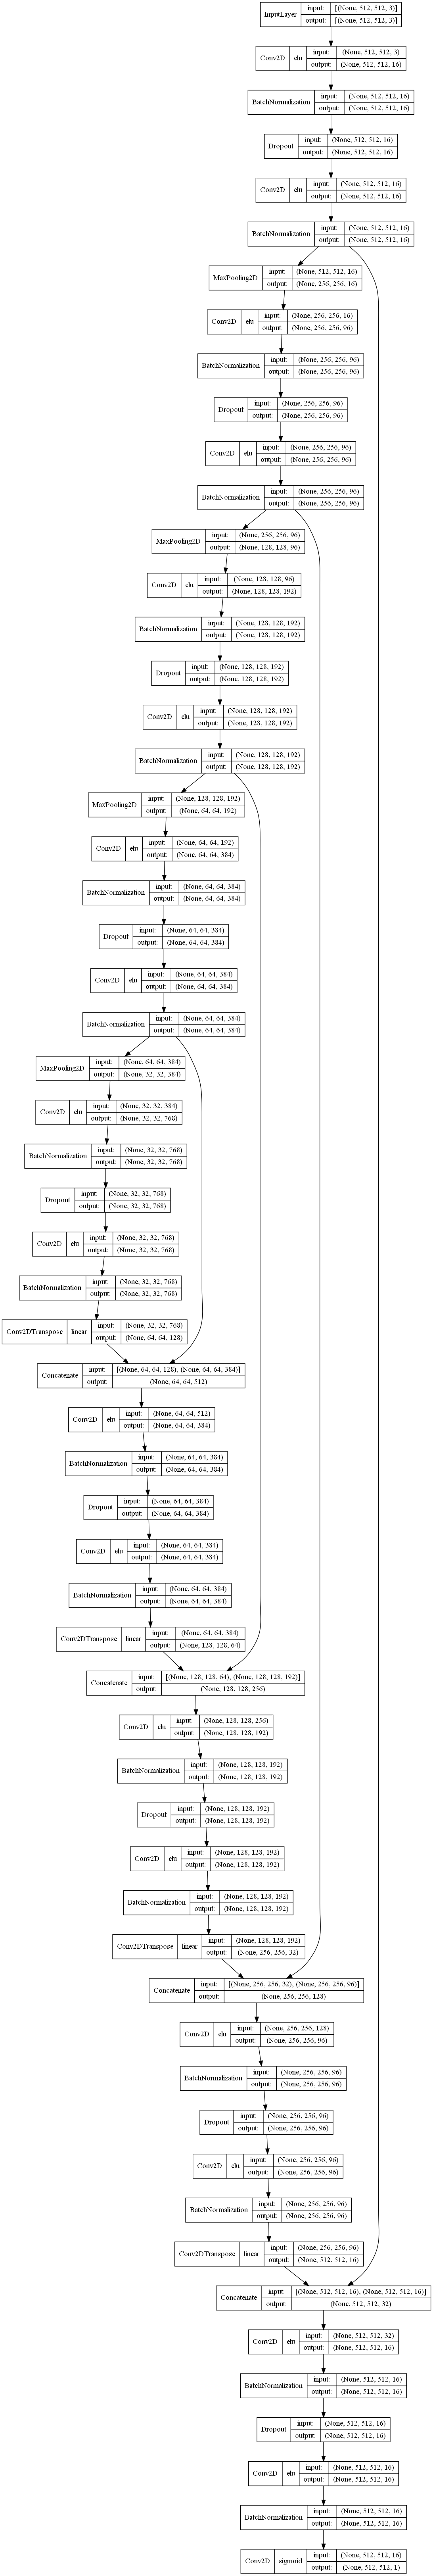

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='./../Models/unet_struct.png',show_shapes=True, show_layer_activations=True, show_layer_names=False)

from IPython.display import Image as IP_Image
IP_Image(retina=True, filename='./../Models/unet_struct.png')

In [5]:
opt = keras.optimizers.Adam(LEARNING_RATE)
callbacks = create_callbacks(BACKUP_MODEL_PATH, BACKUP_HISTORY_PATH)

model.compile(
      optimizer=opt,
      loss= sm.losses.DiceLoss(),
      metrics=[sm.metrics.IOUScore(threshold=0.1), sm.metrics.FScore(), metric.quality()], run_eagerly=True)

train_gen, val_gen = train_val_generator(IMAGE_WIDTH, IMAGE_HEIGHT, ROOT, TRAIN_DIR, BATCH_SIZE, seed,
                                         use_aug=USE_AUGMENTATION)


Found 196 files belonging to 1 classes.
Using 181 files for training.
Found 196 files belonging to 1 classes.
Using 15 files for validation.
Found 196 files belonging to 1 classes.
Using 181 files for training.
Found 196 files belonging to 1 classes.
Using 15 files for validation.


In [4]:
"""Load Model backup to resume training after crash or break or for pretraining"""
model = load_model(BACKUP_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore(), "quality":metric.quality()})

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("steps per epoch:", train_gen.samplesPerBatch, "steps per validation:", val_gen.samplesPerBatch,)

history = model.fit(train_gen.data,  validation_data=val_gen.data, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

Num GPUs Available:  1
steps per epoch: 91 steps per validation: 8
Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 0.9820 - iou_score: 0.0072 - f1-score: 0.0179 - quality: 0.0253
Epoch 1: val_loss improved from inf to 0.97991, saving model to ./../Models\backup.h5
91/91 [==============================] - 56s 533ms/step - loss: 0.9820 - iou_score: 0.0072 - f1-score: 0.0179 - quality: 0.0253 - val_loss: 0.9799 - val_iou_score: 0.0090 - val_f1-score: 0.0206 - val_quality: 0.0301 - lr: 1.0000e-04
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.9791 - iou_score: 0.0087 - f1-score: 0.0217 - quality: 0.0291
Epoch 2: val_loss did not improve from 0.97991
91/91 [==============================] - 46s 500ms/step - loss: 0.9791 - iou_score: 0.0087 - f1-score: 0.0217 - quality: 0.0291 - val_loss: 0.9799 - val_iou_score: 0.0088 - val_f1-score: 0.0188 - val_quality: 0.0294 - lr: 1.0000e-04
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss:

KeyboardInterrupt: 

Time of saving model: 2022-11-11 03:39:59.068012


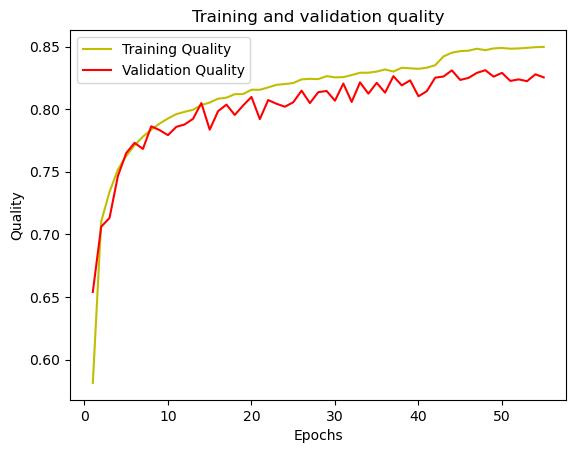

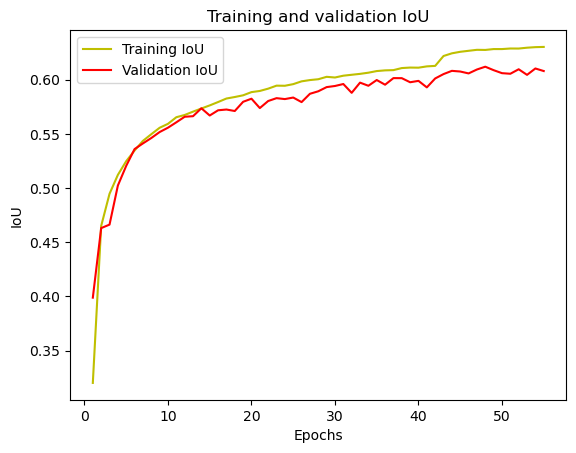

In [5]:
model_path = "./../Models/Roads/triple-param/road_mapper_scratch_Combined_Aug.h5"
save_model(model, model_path=model_path, csv_history_path_to_delete=BACKUP_HISTORY_PATH)
plot_history(history, model_path)

In [6]:
import os
os.system("shutdown /s /t 1")

0